In [1]:
from scipy.spatial.distance import cdist
import numpy as np

class ClusterSimilarityMatrix():
    
    def __init__(self) -> None:
        self._is_fitted = False

    def fit(self, y_clusters):
        if not self._is_fitted:
            self._is_fitted = True
            self.similarity = self.to_binary_matrix(y_clusters)
            return self

        self.similarity += self.to_binary_matrix(y_clusters)

    def to_binary_matrix(self, y_clusters):
        y_reshaped = np.expand_dims(y_clusters, axis=-1)
        return (cdist(y_reshaped, y_reshaped, 'cityblock')==0).astype(int)


class EnsembleCustering():
    def __init__(self, base_estimators, aggregator, distances=False):
        self.base_estimators = base_estimators
        self.aggregator = aggregator
        self.distances = distances

    def fit(self, X):
        X_ = X.copy()

        clt_sim_matrix = ClusterSimilarityMatrix()
        for model in self.base_estimators:
            clt_sim_matrix.fit(model.fit_predict(X=X_))
        
        sim_matrix = clt_sim_matrix.similarity
        self.cluster_matrix = sim_matrix/sim_matrix.diagonal()

        if self.distances:
            self.cluster_matrix = np.abs(np.log(self.cluster_matrix + 1e-8)) # Avoid log(0)

    def fit_predict(self, X):
        self.fit(X)
        y = self.aggregator.fit_predict(self.cluster_matrix)
        return y

Dataset

In [2]:
from sklearn.cluster import SpectralClustering, AgglomerativeClustering

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
import seaborn as sns

import pandas as pd

n_clusters= 3

<AxesSubplot:>

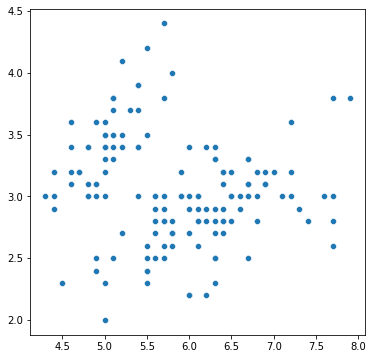

In [3]:
from sklearn.datasets import load_iris

# Cargar el conjunto de datos Iris
iris = load_iris()

# Crear un DataFrame con las características y etiquetas
df = pd.DataFrame(data=iris.data, columns=['sepal_length', ' sepal_width', ' petal_length', ' petal width'])
df['class'] = iris.target  # Agregar la columna de etiquetas al DataFrame


# Selecciona las características para el clustering - sin etiqueta
values = df[['sepal_length', ' sepal_width', ' petal_length', ' petal width']].values


fig, ax = plt.subplots(figsize=(6,6))
sns.scatterplot(x=values[:,0], y=values[:,1], ax=ax)

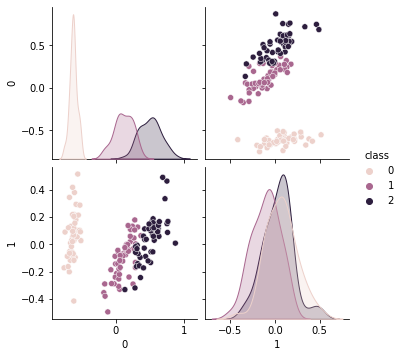

In [4]:
#Hacer PCA para reducir a dos dimensiones
num_data = df.select_dtypes('float64')
data_transformed_ = (num_data-num_data.min())/(num_data.max()-num_data.min())
pca = PCA(n_components=2)
pca.fit(data_transformed_.to_numpy())

projected = pca.transform(data_transformed_.to_numpy())
projected = pd.DataFrame(projected)
projected['class'] = df['class'].values

g = sns.pairplot(projected[[0,1,'class']], hue="class")

iris = projected.values
# Selecciona las características para el clustering - sin etiqueta
X_vectors = projected[[0, 1]].values

Text(0.5, 1.0, 'Original\n(n_clusters=3)')

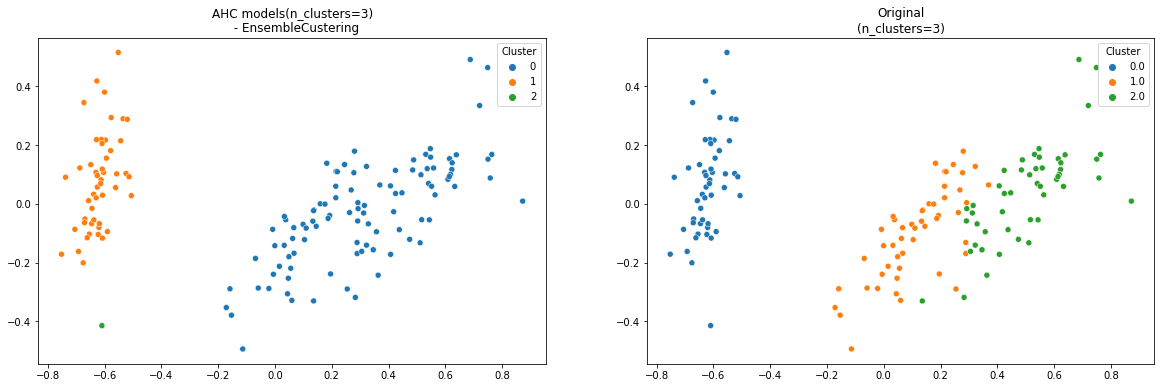

In [5]:
#Trabajando solo con un método de AHC
# Método de enlace de single (simple)
agglomerative_single = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='average')

single = agglomerative_single.fit_predict(X_vectors)

fig, ax = plt.subplots( figsize=(20,6), ncols=2 )

sns.scatterplot(
    x=X_vectors[:,0], 
    y=X_vectors[:,1], 
    hue=single, 
    palette='tab10',
    ax=ax[0]
)

sns.scatterplot(
    x=iris[:,0], 
    y=iris[:,1], 
    hue=iris[:, -1], 
    palette='tab10',
    ax=ax[1]
)


ax[0].legend(loc='upper right', title='Cluster')
ax[1].legend(loc='upper right', title='Cluster')

ax[0].set_title(f"AHC models(n_clusters=3)\n  - EnsembleCustering")
ax[1].set_title(f"Original\n(n_clusters=3)")

In [6]:
# Método de enlace completo
agglomerative_complete = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='complete')

# Método de enlace promedio
agglomerative_average = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='average')

# Método de enlace de Ward
agglomerative_ward = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')

# Método de enlace de single (simple)
agglomerative_single = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='single')

#concatenar los resultados de los 4 métodos
clustering_models = [agglomerative_complete, agglomerative_average, agglomerative_ward, agglomerative_single]

aggregator_clt = SpectralClustering(n_clusters=n_clusters, affinity="precomputed")

ens_clt=EnsembleCustering(clustering_models, aggregator_clt)
assemble = ens_clt.fit_predict(X_vectors)


c:\Users\juanc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Text(0.5, 1.0, 'Original - (n_clusters=3)')

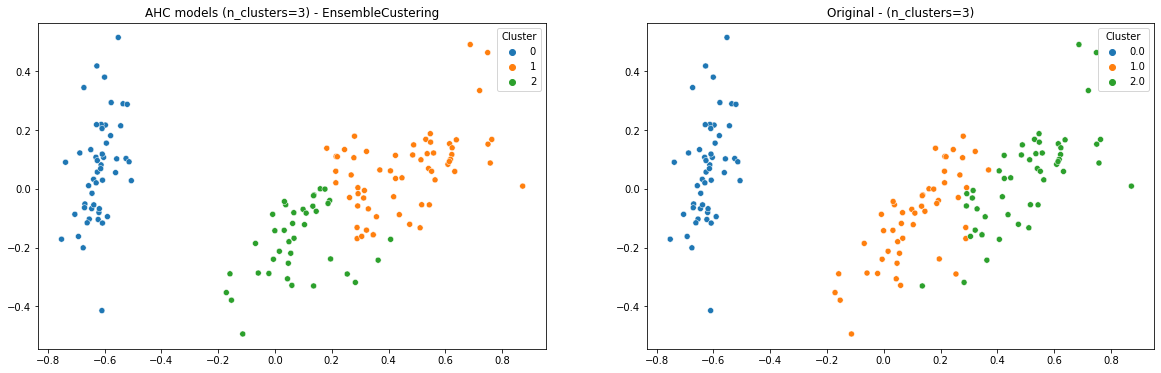

In [7]:
fig, ax = plt.subplots( figsize=(20,6), ncols=2 )

sns.scatterplot(
    x=X_vectors[:,0], 
    y=X_vectors[:,1], 
    hue=assemble, 
    palette='tab10',
    ax=ax[0]
)

sns.scatterplot(
    x=iris[:,0], 
    y=iris[:,1], 
    hue=iris[:, -1], 
    palette='tab10',
    ax=ax[1]
)


ax[0].legend(loc='upper right', title='Cluster')
ax[1].legend(loc='upper right', title='Cluster')

ax[0].set_title(f"AHC models (n_clusters=3) - EnsembleCustering")
ax[1].set_title(f"Original - (n_clusters=3)")

Taller
 * Replique el ejrcicio con el dataset wine y analice los resultados comparando el clustering de un método de AHC con la técnica de ensamblado
 * Use un número de 3 clusters

   alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  od280/od315_of_diluted_wines  proline  class
0    14.23        1.71  2.43               15.6      127.0           2.80        3.06                  0.28             2.29             5.64  1.04                          3.92   1065.0      0
1    13.20        1.78  2.14               11.2      100.0           2.65        2.76                  0.26             1.28             4.38  1.05                          3.40   1050.0      0
2    13.16        2.36  2.67               18.6      101.0           2.80        3.24                  0.30             2.81             5.68  1.03                          3.17   1185.0      0
3    14.37        1.95  2.50               16.8      113.0           3.85        3.49                  0.24             2.18             7.80  0.86                          3.45   1480.0      0
4    13.24        2.59  2.87  

<AxesSubplot:>

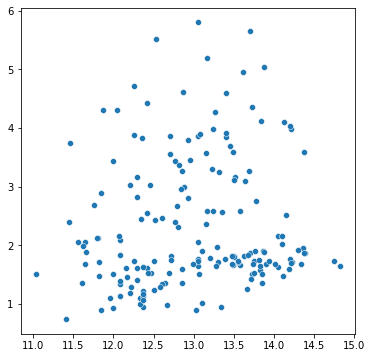

In [8]:
from sklearn.datasets import load_wine

# Cargar el conjunto de datos Wine
wine = load_wine()

# Crear un DataFrame con las características y etiquetas
df = pd.DataFrame(data=wine.data, columns=wine.feature_names)
df['class'] = wine.target  # Agregar la columna de etiquetas al DataFrame

print(df.head().to_string())

# Selecciona las características para el clustering - sin etiqueta
values = wine.data

fig, ax = plt.subplots(figsize=(6,6))
sns.scatterplot(x=values[:,0], y=values[:,1], ax=ax)
